Created on December 30th 2020 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# Small experiment of document mining with various techniques Part 3

In [1]:
#check python version and path
import sys
sys.executable

'/opt/anaconda3/envs/base38/bin/python'

In [2]:
#import main libraries
import numpy as np
import PyPDF2
import spacy
import pandas as pd
import re
from pptx import Presentation
import pdftotext
import texthero as hero

In [3]:
# validate spacy language models just in case, this command does not work on Mac ARM systems unless you have installed the brew workaround and reinstalled python
!python -m spacy validate

/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: No module named spacy


In [4]:
# function to read PDF files using PYPdf2
def readPdfFilePY(filename):
    text=""
    read_pdf = PyPDF2.PdfFileReader(filename,'rb')   
    for i in range(read_pdf.getNumPages()):
        page = read_pdf.getPage(i)
        txt=page.extractText()
        text=text+txt
    return text


In [5]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [6]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [7]:
#path of input folder
path='./samplesdocs/' 

## Process all directory files with spacy

In [8]:
# helper function to process documents in an apply function and return the nlp object
def processDoc(doc):
    return nlp(doc)

In [9]:
# load spacy with large English model
# nlp = spacy.load("en-core-web-lg") -- was working on Windows, but now on a Mac
import en_core_web_lg
nlp = en_core_web_lg.load()

## Let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

In [10]:
# go through the folder and read all pdf and pptx files
docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])
fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)
print('Number of read files:',fullDocs.shape[0])

Number of read files: 8


In [11]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:197501.375
Min length of text:17987
Max length of text:464271


In [12]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
0,./samplesdocs/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,"(application, ai, insurtech, real, estate, tec...",3732,1509
1,./samplesdocs/Technology-and-innovation-in-the...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,"(technology, innovation, insurance, sector, te...",16763,4237
2,./samplesdocs/sigma-5-2020-en.pdf,pdf,No 5 /2020\n\n\n\n\n...,machine intelligence executive summary machine...,"(machine, intelligence, executive, summary, ma...",14512,4342
3,./samplesdocs/Issues_Paper_on_Increasing_Digit...,pdf,Issues Paper on Increasing Digitalisatio...,issues paper increasing digitalisation insuran...,"(issues, paper, increasing, digitalisation, in...",15390,3685
4,./samplesdocs/Digital-disruption-in-Insurance.pdf,pdf,Digital disruption\nin insurance:\nCutting thr...,digital disruption insurance cutting noise con...,"(digital, disruption, insurance, cutting, nois...",34531,7067


In [22]:
# import additional spacy symbols and stop words
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
from spacy.lang.en.stop_words import STOP_WORDS

In [24]:
ents=[]
for doc in fullDocs.NLP:
    # all entities
    words=[]
    words += [token.lemma_ for token in doc if token.is_stop != True and token.is_punct != True \
              and token.is_space != True and token.pos != NUM and token.pos != SYM \
              and token.text != '©' and (not token.text in STOP_WORDS)and (not token.lemma_ in STOP_WORDS)]
    ents.append(' '.join(words))
entitiesdf=pd.DataFrame(ents)
entitiesdf.head()

,0
0,application ai insurtech real estate technolog...
1,technology innovation insurance sector technol...
2,machine intelligence executive summary machine...
3,issue paper increase digitalisation insurance ...
4,digital disruption insurance cut noise content...


# Let us compare documents similarities using spacy similarity

In [13]:
similarityList=[]
for doc in fullDocs.NLP:
    docSimilarity=[]
    for compDoc in fullDocs.NLP:
        docSimilarity.append(doc.similarity(compDoc))
    similarityList.append(docSimilarity)

In [14]:
similarityDF= pd.DataFrame(data=similarityList)

In [15]:
similarityDF.head()

,0,1,2,3,4,5,6,7
0,1.000000,0.966452,0.942421,0.960628,0.956143,0.959908,0.925205,0.971377
1,0.966452,1.000000,0.968809,0.991848,0.980943,0.970273,0.968357,0.987504
2,0.942421,0.968809,1.000000,0.972139,0.976786,0.964634,0.965845,0.977554
3,0.960628,0.991848,0.972139,1.000000,0.982518,0.973535,0.970810,0.990891
4,0.956143,0.980943,0.976786,0.982518,1.000000,0.965047,0.958326,0.989613


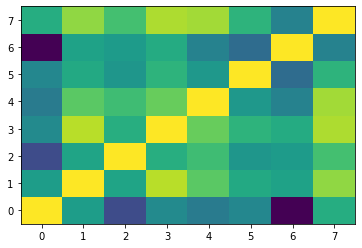

In [16]:
import matplotlib.pyplot as plt
plt.pcolor(similarityDF)
plt.yticks(np.arange(0.5, len(similarityDF.index), 1), similarityDF.index)
plt.xticks(np.arange(0.5, len(similarityDF.columns), 1), similarityDF.columns)
plt.show()

It seems document 0 and document 6 have the lowest similarity amongst all document

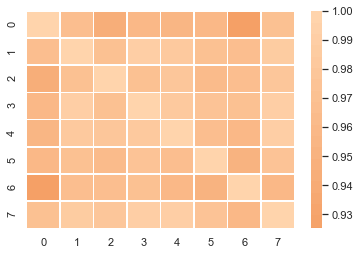

In [18]:
import seaborn as sns
sns.set()

ax = sns.heatmap(similarityDF,linewidths=.5,center=.5)

# Let us use vector norm to calculate their distance

In [23]:
# calculate the norm of the distance of the vectors
similarityList=[]
for doc in fullDocs.NLP:
    docSimilarity=[]
    for compDoc in fullDocs.NLP:
        docSimilarity.append(np.linalg.norm(doc.vector-compDoc.vector))
    similarityList.append(docSimilarity)

In [24]:
similarityDFVec= pd.DataFrame(data=similarityList)

In [25]:
similarityDFVec.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.813616,1.005958,0.909846,0.927239,0.864066,1.147514,0.802749
1,0.813616,0.000000,0.727521,0.383655,0.574516,0.708983,0.739546,0.467494
2,1.005958,0.727521,0.000000,0.699998,0.633790,0.773400,0.768292,0.624837
3,0.909846,0.383655,0.699998,0.000000,0.556338,0.682422,0.718512,0.402149
4,0.927239,0.574516,0.633790,0.556338,0.000000,0.776320,0.853526,0.426797


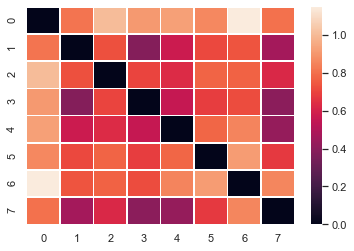

In [26]:
sns.set()

ax = sns.heatmap(similarityDFVec,linewidths=.5)

Again documents 0 and 6 seem to have the longest distance to each other

# Let us use entity vector average  to calculate similarities

In [30]:
# most frequestentities
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
            if ent.label_!= 'MONEY' and ent.label_!= 'CARDINAL' and ent.label_!= 'QUANTITY' \
            and ent.label_!= 'PERCENT' and ent.label_!= 'TIME' and ent.label_!= 'ORDINAL' \
            and ent.label_!= 'DATE' and ent.label_!= 'PERSON' and ent.label_!= 'GPE':
                if ent.text not in STOP_WORDS:
                    entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
print(commonEntities)

[('eu', 205), ('insurtech', 79), ('european', 60), ('iais executive committee', 36), ('oecd', 27), ('mckinsey', 26), ('fra', 25), ('swiss', 23), ('gdpr', 22), ('digital', 21), ('ec', 19), ('fca', 17), ('europe', 17), ('mi', 15), ('chinese', 14), ('regtech', 13), ('luxembourg publications office', 13), ('dlt', 11), ('european commission', 11), ('allianz', 10), ('german', 10), ('alibaba', 10), ('accenture', 9), ('q4', 9), ('cb', 9), ('rpa', 9), ('capgemini world', 8), ('facebook', 8), ('amazon', 8), ('swiss sigma', 8), ('sigma', 8), ('dutch', 8), ('coe', 8), ('adobe', 8), ('fintech', 7), ('aviva', 7), ('cdo', 7), ('google', 7), ('bima', 6), ('european union', 6)]


In [31]:
def getAverageEntityVector(doc):
    vectorAvg = 0
    i=0
    for ent in doc.ents:
        if ent.label_!= 'MONEY' and ent.label_!= 'CARDINAL' and ent.label_!= 'QUANTITY' \
        and ent.label_!= 'PERCENT' and ent.label_!= 'TIME' and ent.label_!= 'ORDINAL' \
        and ent.label_!= 'DATE' and ent.label_!= 'PERSON' and ent.label_!= 'GPE':
            if ent.text not in STOP_WORDS:
                vectorAvg += ent.vector
                i+=1
    if i>0:
        vectorAvg=vectorAvg/i
    else:
        vectotAvg=float('Inf')
    return vectorAvg

In [32]:
# calculate average entity vector for documents
entitiesVec=[]
for doc in fullDocs.NLP:
    # all entities
    vectorAvg=getAverageEntityVector(doc)
    entitiesVec.append(vectorAvg)    


In [33]:
# compare all documents using entityt similarity vectors
similarityList=[]
for ents in entitiesVec:
    docSimilarity=[]
    for entComp in entitiesVec:
        #docSimilarity.append(np.dot(doc.vector,compDoc.vector))
        docSimilarity.append(np.linalg.norm(ents-entComp))
    similarityList.append(docSimilarity)

In [34]:
similarityDFVecAvg= pd.DataFrame(data=similarityList)

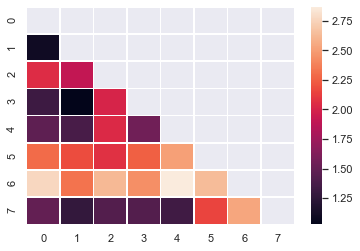

In [35]:
sns.set()
mask = np.zeros_like(similarityDF, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(similarityDFVecAvg,linewidths=.5, mask=mask)

In [36]:
def searchClosestDocumentDocLevel(text):
    searchQueryNLP=nlp(text)
    simQuery=[]
    for i,doc in fullDocs.iterrows():
        simQuery.append((np.linalg.norm(doc.NLP.vector-searchQueryNLP.vector),i))
    simQuery.sort()
    idMin=simQuery[0][1]
    return idMin

In [37]:
def searchClosestDocumentEntLevel(text):
    searchQueryNLP=nlp(text)
    simQuery=[]
    for i,doc in fullDocs.iterrows():
        simQuery.append((np.linalg.norm(getAverageEntityVector(doc.NLP)-getAverageEntityVector(searchQueryNLP)),i))
    simQuery.sort()
    idMin=simQuery[0][1]
    return idMin

In [45]:
text='LOOKING FOR INNOVATION IN CLAIMS PROCESSING'
id= searchClosestDocumentDocLevel(text)
fullDocs.iloc[id].Name

'./samplesdocs/Digital-disruption-in-Insurance.pdf'

In [40]:
text='ai ethics in the european right'
id= searchClosestDocumentDocLevel(text)
fullDocs.iloc[id].Name

'./samplesdocs/fra-2020-artificial-intelligence_en.pdf'

In [42]:
text='latest innovation in underwiting ad how to use artificial intelligence'
id= searchClosestDocumentEntLevel(text)
fullDocs.iloc[id].Name

'./samplesdocs/Module-1-Lecture-Slides.pdf'

In [44]:
text='what are the main digital innovations in insurance'
id= searchClosestDocumentEntLevel(text)
fullDocs.iloc[id].Name

'./samplesdocs/Module-1-Lecture-Slides.pdf'

# Let us use sentences vector  to calculate similarities

In [46]:
def getAverageSentenceVector(doc):
    vectorAvg = 0
    i=0
    for sent in doc.sents:
        vectorAvg += sent.vector
        i+=1
    if i>0:
        vectorAvg=vectorAvg/i
    else:
        vectorAvg=float('Inf')
    return vectorAvg

In [47]:
# calculate average entity vector for documents
entitiesVec=[]
for doc in fullDocs.NLP:
    # all entities
    vectorAvg=getAverageSentenceVector(doc)
    entitiesVec.append(vectorAvg)  

In [48]:
# compare all documents using sentence similarity vectors
similarityList=[]
for ents in entitiesVec:
    docSimilarity=[]
    for entComp in entitiesVec:
        #docSimilarity.append(np.dot(doc.vector,compDoc.vector))
        docSimilarity.append(np.linalg.norm(ents-entComp))
    similarityList.append(docSimilarity)

In [49]:
similarityDFVecAvg= pd.DataFrame(data=similarityList)

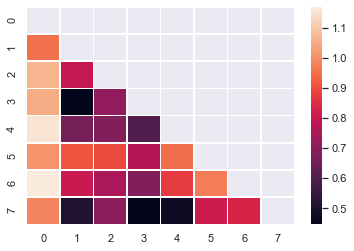

In [50]:
sns.set()
mask = np.zeros_like(similarityDF, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(similarityDFVecAvg,linewidths=.5, mask=mask)

In [51]:
def searchClosestDocumentSentLevel(text):
    searchQueryNLP=nlp(text)
    simQuery=[]
    for i,doc in fullDocs.iterrows():
        simQuery.append((np.linalg.norm(getAverageSentenceVector(doc.NLP)-getAverageSentenceVector(searchQueryNLP)),i))
    simQuery.sort()
    idMin=simQuery[0][1]
    return idMin

In [52]:
text='What are innovations in underwriting ?'
id= searchClosestDocumentSentLevel(text)
fullDocs.iloc[id].Name

'./samplesdocs/Digital-disruption-in-Insurance.pdf'

In [53]:
text='What about claim notification.'
id= searchClosestDocumentSentLevel(text)
fullDocs.iloc[id].Name

'./samplesdocs/fra-2020-artificial-intelligence_en.pdf'